# Solving the spherical hole in a tensile field problem

In this notebook, we develop the spherical harmonic solution of the tensile-hole problem. The problem can be described in the following figure:

![Decompose tensile hole problem](figures/tensile_hole_decompose.png)

In this approach, we only solve the image stress problem (right figure).

Here the image traction can be calculated as:

$$
\mathbf{T}^\infty = \mathbf{\sigma}\cdot\mathbf{n} = \hat{\mathbf{e}}_z S_0\cos\theta \\
\mathbf{T}^{img} = -\mathbf{T}^\infty = -\hat{\mathbf{e}}_z S_0\cos\theta =
-\hat{\mathbf{e}}_z S_0\sqrt\frac{1}{3}Y_1^0
$$

Then we set up the basic conditions of the problem:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyshtools
import sys
sys.path.append('../module/')
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord
from SHUtil import SHCilmToVector, lmk2K, K2lmk
import time

S0 = 1
a = 1
mu = 1
nu = 1./3

#### traction mode matrix info ####
lJmax = 7 # max l degree for saving a single mode
lKmax = 4 # max cutoff l degree for modes
LJ = (lJmax+1)**2
LK = (lKmax+1)**2

#### create meshgrid for evaluation ####
x_grid = np.linspace(1.01, 5)
Y, X, Z = np.meshgrid([0, ], x_grid, [0, ])

R, THETA, PHI = CartCoord_to_SphCoord(X, Y, Z)

T_usr_vec = np.empty(3*LJ, dtype=np.complex)
for k in range(3):
    T_usr_cilm = pyshtools.SHCoeffs.from_zeros(lmax=lJmax, kind='complex')
    if k == 2:
        T_usr_cilm.set_coeffs(-S0/np.sqrt(3), 1, 0)
    T_usr_vec[LJ*k:LJ*(k+1)] = SHCilmToVector(T_usr_cilm.to_array(), lmax = lJmax)

#### load the full and sub matrix ####
import scipy.sparse as spm
from scipy.io import loadmat, savemat
from ShElastic import calSmode
from SHBV import generate_submat, visualize_Cmat

shtype = 'irr'
Tmodes = loadmat('Tmodes.mat')
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
ticT = time.time()
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax)
tocT = time.time()

Then we solve the linear system:

In [2]:
from SHBV import print_SH_mode
ticA = time.time()
A = spm.linalg.lsqr(Cmat, T_usr_vec.transpose())
tocA = time.time()
print('Residual:', A[3], 'Time:', tocA-ticA)
A_sol = np.zeros_like(A[0])
A_sol[np.abs(A[0]) > 1e-8] = A[0][np.abs(A[0]) > 1e-8]
print('Solution:', A_sol.size)
index_sol = print_SH_mode(A_sol)

Residual: 3.546821724485852e-15 Time: 0.02680182456970215
Solution: 75
index: 1 (1, -1, 0) coeff: (-0.0452320549093+2.04116979091e-17j)
index: 3 (1, 1, 0) coeff: (0.0452320549093+2.44668299803e-17j)
index: 11 (3, -1, 0) coeff: (-0.0216613346925+1.52596631885e-17j)
index: 13 (3, 1, 0) coeff: (0.0216613346925+1.35604250673e-17j)
index: 26 (1, -1, 1) coeff: (-9.97108091896e-19-0.0452320549093j)
index: 28 (1, 1, 1) coeff: (-3.09351626655e-18-0.0452320549093j)
index: 36 (3, -1, 1) coeff: (-7.96204931068e-18-0.0216613346925j)
index: 38 (3, 1, 1) coeff: (9.25766025524e-18-0.0216613346925j)
index: 52 (1, 0, 2) coeff: (-0.206665153176+6.44016530896e-19j)
index: 62 (3, 0, 2) coeff: (0.0375185322472-1.88952599553e-19j)


And integrate the stress solution:

In [3]:
from SHBV import fast_stress_solution

Smodes = loadmat('Smodes.mat')
Smodes = (Smodes['S1'+shtype], Smodes['S2'+shtype], Smodes['S3'+shtype], Smodes['S0'+shtype])
fullSmodes = calSmode(Smodes, mu, nu)
Smodes = generate_submat(mu, nu, fullSmodes, lKmax, lJmax, kJ=9)

tic = time.time()
sigma_tot = fast_stress_solution(A_sol, X, Y, Z, Smodes, lKmax, lJmax)
toc = time.time()
print(sigma_tot.shape, toc-tic)

(50, 1, 1, 3, 3) 0.03168439865112305


We compare the solution with the analytical solution of the problem:

(50, 1, 1) (50, 1, 1)
(31, 2) [ 0.02620815  0.00063735  0.00114668  0.00920845  0.00335156  0.01077921
  0.00538657  0.00463259  0.00387901  0.00215444  0.00198832  0.00299757
  0.00738325  0.00462743  0.00331101  0.0079818   0.00596547  0.00693202
  0.00761445  0.0061786   0.00722109  0.00670993  0.00720561  0.00700455
  0.00669977  0.00649784  0.00627261  0.00581221  0.00471659  0.00189815
  0.00472782]


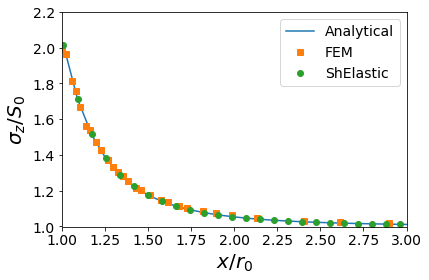

In [4]:
# Analytical result
K1 = -5*S0*a**3/2/(7-5*nu)
K2 = S0*(1-5*nu)*a**3/(7-5*nu)
A1 = S0*a**5/2/(7-5*nu)

sz = S0*(1+(4-5*nu)*a**3/2/(7-5*nu)/R**3+9*a**5/2/(7-5*nu)/R**5)
print(X.shape, sz.shape)

# FEM result
FEM = loadmat('../testdata/tensile_hole1.mat')['M'][::16, :]
rF = FEM[:, 0]
sz_FEM=S0*(1+(4-5*nu)*a**3/2/(7-5*nu)/rF**3+9*a**5/2/(7-5*nu)/rF**5)

print(FEM.shape, np.abs(sz_FEM+FEM[:,1]-1)/sz_FEM)

plt.plot(X.flatten(), sz.flatten(), label='Analytical')
#plt.plot(rF, sz_FEM)
plt.plot(FEM[:, 0], -FEM[:, 1]+1, 's', label='FEM')
total_time = 1000*(toc-tic + tocA-ticA) #+ tocT-ticT
plt.plot(X.flatten(), sigma_tot[:, :, :, 2, 2].flatten() + S0, 'o',label='ShElastic')
plt.legend(fontsize=14)
plt.xlabel(r'$x/r_0$', fontsize=20)
plt.ylabel(r'$\sigma_z/S_0$', fontsize=20)
plt.xlim(1, 3)
plt.ylim(1, 2.2)
plt.tick_params(labelsize=14)
plt.tight_layout()
#plt.savefig('../figures/case1-result.png', dpi=1000, transparent=True)
plt.show()

In [5]:
from scipy.io import savemat, whosmat

n = 3
filename = '../figures/case1-result.mat'
obj_x = np.empty((n,), dtype=np.object)
obj_y = np.empty((n,), dtype=np.object)
obj_label = np.empty((n,), dtype=np.object)

obj_x[0], obj_x[1], obj_x[2] = (X.flatten(), FEM[:, 0], X.flatten())
obj_y[0], obj_y[1], obj_y[2] = (sz.flatten(), -FEM[:, 1]+1, sigma_tot[:, :, :, 2, 2].flatten() + S0)
obj_label[0] = 'Analytical'
obj_label[1] = 'FEM'
obj_label[2] = 'ShElastic'

savemat(filename, {'X': obj_x, 'Y': obj_y, 'label': obj_label})
whosmat(filename)

[('Y', (1, 3), 'cell'), ('label', (1, 3), 'cell'), ('X', (1, 3), 'cell')]

## Elastic Energy

We then calculate the corresponding elastic energy:

In [6]:
from ShElastic import calUmode

Umodes = loadmat('Umodes.mat')
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax)
Uvec = Dmat.dot(A_sol)

E=2*np.pi*np.multiply(Uvec, T_usr_vec).sum()
print('total elastic energy from SH:', E)

total elastic energy from SH: (-0.785398163397+2.7949400427e-18j)


In [7]:
Emodes = np.dot(A_sol, 2*np.pi*Cmat.multiply(Dmat.conjugate()).sum(axis=0).T).flatten()
print('total elastic energy from summing up SH modes', Emodes)

total elastic energy from summing up SH modes [[-0.5739857+12.21459631j]]


In [8]:
from SHBV import fast_displacement_solution

Ngrid = 30
latglq, longlq = pyshtools.expand.GLQGridCoord(Ngrid)
theta = np.radians(90-latglq)
phi = np.radians(longlq)
#print(theta)
#print(phi)
dtheta = np.gradient(theta)
dphi = np.gradient(phi)
#zero, w = pyshtools.expand.SHGLQ(lmax_sub)

TT, PP = np.meshgrid(theta, phi)
dT, dP = np.meshgrid(dtheta, dphi)
dA = np.sin(TT)*dT*dP
ZZ = np.cos(TT)
XX = np.sin(TT)*np.cos(PP)
YY = np.sin(TT)*np.sin(PP)
RR = np.sqrt(XX**2+YY**2+ZZ**2)
NN = np.stack((XX/RR, YY/RR, ZZ/RR), axis=-1)

In [9]:
Umesh = fast_displacement_solution(A_sol, XX, YY, ZZ, Dmat, lKmax, lJmax)
Smesh = fast_stress_solution(A_sol, XX, YY, ZZ, Smodes, lKmax, lJmax)
Tmesh = np.sum(Smesh*NN[...,np.newaxis,:], axis=-1)

In [10]:
W = (1/2*np.sum(Umesh*Tmesh, axis=-1)*dA).sum()
print('numerical elastic energy:', W*mu/S0**2)
print('total elastic energy from SH:', E*mu/S0**2)
print('total elastic energy from summing up SH modes', Emodes*mu/S0**2)

numerical elastic energy: -0.785480631386
total elastic energy from SH: (-0.785398163397+2.7949400427e-18j)
total elastic energy from summing up SH modes [[-0.5739857+12.21459631j]]


If we calculate the cross terms of the energy:

4 4


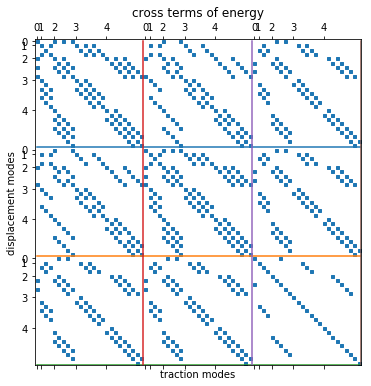

In [11]:
from SHBV import visualize_Cmat

Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax)

plt.figure(figsize=(6,6))
Ecross = 2*np.pi*Dmat.H*Cmat
visualize_Cmat(Ecross)
plt.title('cross terms of energy')
plt.xlabel('traction modes')
plt.ylabel('displacement modes')
plt.show()

(75,) (75, 75)


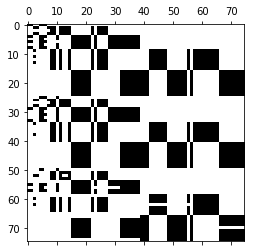

In [12]:
A = Ecross.todense()
w,v = np.linalg.eig(A)
print(w.shape, v.shape)
plt.spy(v,precision=1e-5)
plt.show()

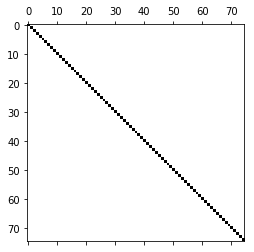

In [13]:
plt.spy(np.linalg.inv(v).dot(A).dot(v),precision=1e-8)
plt.show()

In [14]:
print(np.diag(np.linalg.inv(v).dot(A).dot(v)).real)

[  -8.2894344  -207.43326114 -431.47400186  -84.4739358  -207.43326114
 -207.43326114   -8.2894344   -33.51032164 -431.47400186 -431.47400186
   -8.2894344  -431.47400186  -33.51032164  -33.51032164 -431.47400186
 -796.44144542 -796.44144542 -796.44144542 -796.44144542 -796.44144542
 -796.44144542 -796.44144542  -11.70000181  -44.68042885  -11.70000181
  -11.70000181  -11.70000181  -11.70000181  -44.68042885  -44.68042885
  -44.68042885  -44.68042885  -15.1865233   -15.1865233   -15.1865233
  -15.1865233   -15.1865233   -15.1865233   -15.1865233  -469.08103642
 -469.08103642 -469.08103642  -55.85053606  -55.85053606  -55.85053606
  -55.85053606  -55.85053606  -55.85053606 -469.08103642 -469.08103642
 -469.08103642 -469.08103642 -469.08103642 -469.08103642 -469.08103642
  -55.85053606 -469.08103642 -250.39657002 -250.39657002 -250.39657002
 -250.39657002 -250.39657002 -250.39657002 -250.39657002 -250.39657002
 -250.39657002  -67.02064328  -67.02064328  -67.02064328  -67.02064328
  -67.0

## Energy minimization

In [15]:
print(Umesh.shape, Tmesh.shape, a, XX.shape)
print(Umesh.max())

(61, 31, 3) (61, 31, 3) 1 (61, 31)
0.373907805682


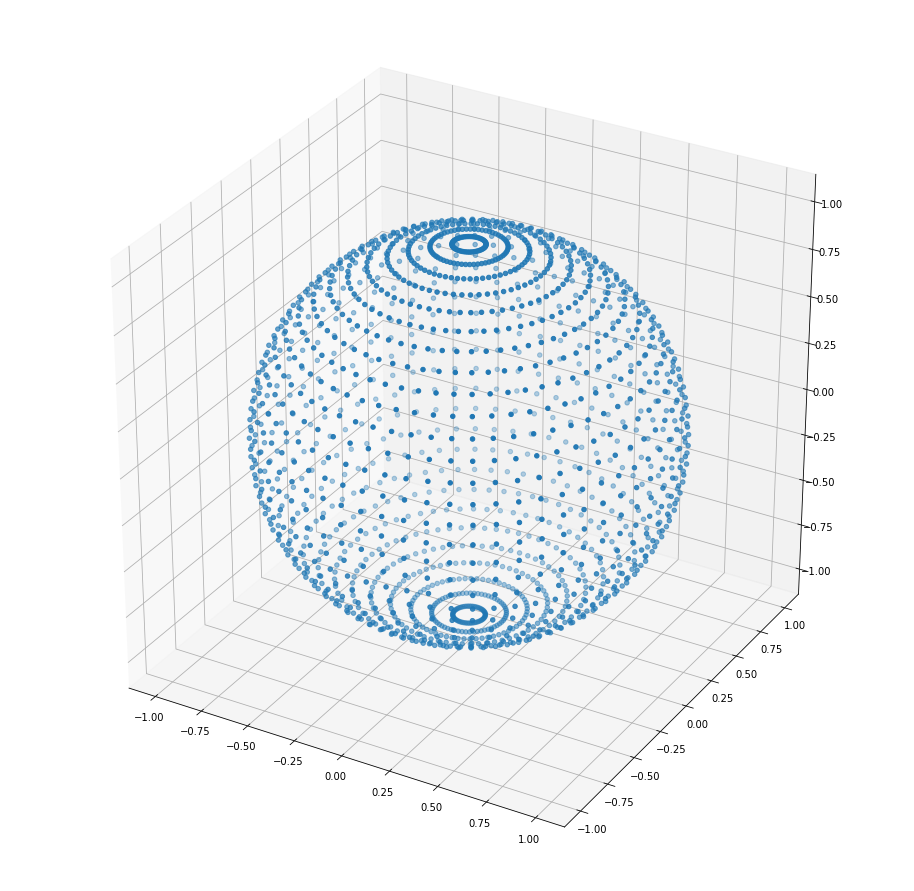

In [16]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(XX, YY, ZZ)
plt.show()

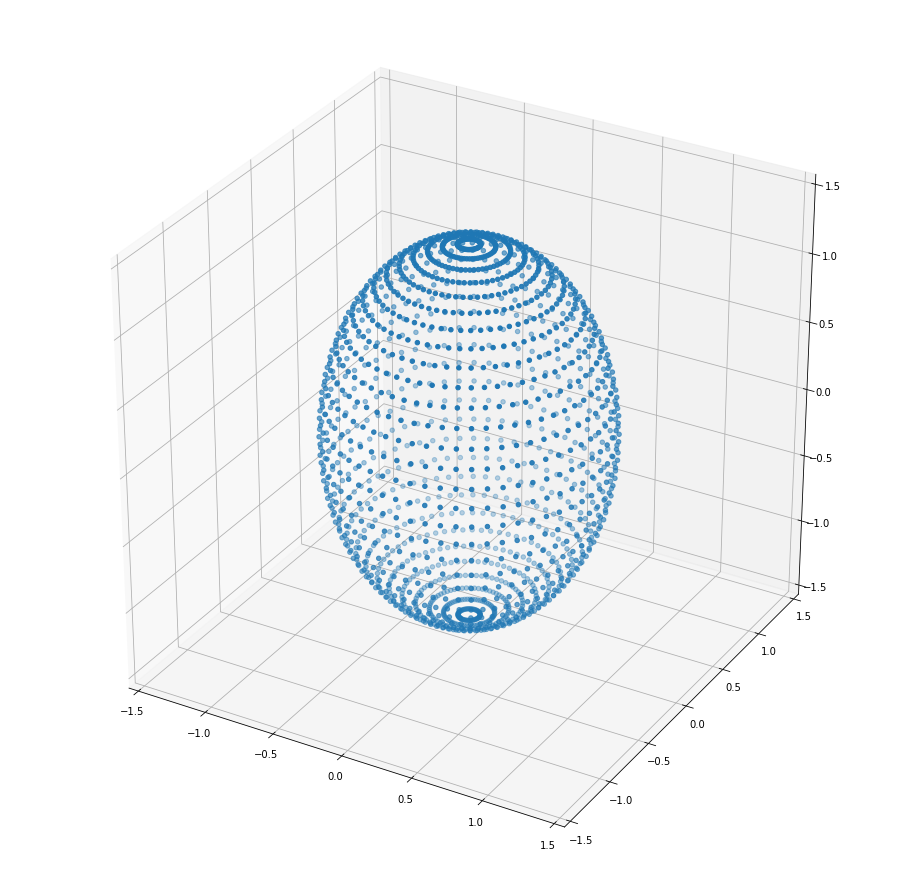

In [17]:
data = Umesh + np.stack([XX,YY,ZZ], axis=-1)

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

# Create cubic bounding box to simulate equal aspect ratio
data_reshape = data.reshape((np.int(data.size/3), 3))
axis_range = data_reshape.max(axis=0)-data_reshape.min(axis=0)
axis_center= data_reshape.max(axis=0)+data_reshape.min(axis=0)
#print(axis_range, axis_center)
max_range = axis_range.max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*axis_center[0]
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*axis_center[1]
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*axis_center[2]
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

ax.scatter3D(data[...,0], data[...,1], data[...,2])
plt.show()

In [18]:
from SHBV import fast_energy_solution


def E_disp(U0, Dmat, Cmat, data, lKmax=20, lJmax=23):
    LJ = (lJmax+1)**2
    #print(LJ)
    X = data[..., 0]; Y = data[..., 1]; Z = data[..., 2];
    #print(data.shape[:-1] + (2,))
    U0 = U0.reshape(data.shape[:-1] + (2,))
    #print(U0.shape)
    THETA = U0[...,0]; PHI = U0[...,1]; r0 = 1;
    X0,Y0,Z0 = SphCoord_to_CartCoord(r0, THETA, PHI)

    U_usr_mesh = np.stack([X-X0, Y-Y0, Z-Z0], axis=-1)
    #print(U_usr_mesh.shape)
    U_usr_vec = np.empty(3*LJ, dtype=np.complex)
    for k in range(3):
        U_usr_grid = pyshtools.SHGrid.from_array(U_usr_mesh[...,k].T.astype(np.complex), grid='GLQ')
        U_usr_cilm = U_usr_grid.expand(lmax_calc=lJmax)
        U_usr_vec[LJ*k:LJ*(k+1)] = SHCilmToVector(U_usr_cilm.to_array(), lmax = lJmax)
    B = spm.linalg.lsqr(Dmat, U_usr_vec.transpose())
    #B_sol=print_SH_mode(B[0], m_dir=3, etol=1e-8)
    return fast_energy_solution(B[0], Dmat, Cmat)

In [19]:
from scipy.optimize import minimize

tic = time.time()
init = np.stack([TT, PP], axis=-1)
print(lKmax, lJmax)
Ep = E_disp(init.flatten(), Dmat, Cmat, data, lKmax, lJmax)
toc = time.time()
print(Ep, toc-tic)

4 7
-0.785398163397 0.19102025032043457


In [20]:
Ngrid = 30
theta0 = np.arange(Ngrid+1)/Ngrid*np.pi
phi0 = np.arange(2*Ngrid+1)/Ngrid*np.pi
print(theta0.shape)
print(phi0.shape)
T0, P0 = np.meshgrid(theta0, phi0)
print(T0.shape, P0.shape)

(31,)
(61,)
(61, 31) (61, 31)
